<a href="https://colab.research.google.com/github/antonionipo/Data-analysis-for-populism-in-presidential-speeches/blob/main/data_analysis_for_populism_in_presidential_speeches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis for populism in presidencial speeches

Abstract
What is the most efficient way to ideologically classify a speech? Given the volume of content produced, this dissertation compares two machine learning tools for this purpose. The first is a computational learning model built using RStudio software, while the second is Chat-GPT. The classification object of this project will be official presidential speeches from Brazil (1988-2019), focusing on populism as the ideological aspect. Words characterizing relevant thematic areas will also be analyzed in a more in-depth investigation of the texts to understand the phenomenon of populism. Finally, the efficiency of these two speech classification tools into populist or non-populist will be measured by comparing their results with those obtained by a team of experts. The results obtained will contribute to the methodological debate and aim to provide a tool that facilitates this crucial work for Political Science, being also relevant to society by proposing an analysis of populism among Brazil's executive representatives, a topic of social interest.

Canto (2025)

## Research problem

What is the most efficient way to ideologically classify a speech?


## Data Understanding

Para o desenvolvimento desta pesquisa, foi utilizada a base de dados disponibilizada pelo artigo de Ricci (2021) publicado na Revista Brasileira de Ciências Sociais. Esta base contém uma classificação de discursos presidenciais oficiais brasileiros em populistas ou não populistas sob o critério de contraposição de povo e elite (Hawkins e Kaltwasser, 2017). Nesta base, foi aplicada, inicialmente, a técnica de dicionário para filtrar as potencialmente populistas, com um dicionário feito para indicar frases com palavras referentes ao povo e outro, para a elite. Apenas as que continham palavras de ambos os dicionários foram manualmente classificadas e é essa a amostra que será utilizada nesta análise, podendo ser inteiramente replicada.
É cabível ressaltar que a classificação manual feita por estes autores especialistas é tido como o padrão ouro dentro da análise de texto. Tomando estes dados como corretos, serão aplicadas diferentes técnicas de aprendizado supervisionado e não supervisionado para, observando o desempenho destas, discutir sobre suas aplicações na Ciência Política, assim como em outras áreas de conhecimento. O objetivo central é, desta maneira, a comparação, a contraposição destas diferentes formas de classificação automatizada.
Inicialmente, será feita uma análise do período pós-redemocratização brasileira (1988-2019), de maneira a obter  a pluralidade necessária de discursos, com a comparação e visualização de mudanças ocorridas tanto na frequência quanto na variedade de elementos populistas, formando uma base que contém períodos e elementos populistas e não-populistas.

Canto (2025)

**Desenho metodológico para construção da base de dados**

"Com desenho metodológico misto (mixed methods design), a alternativa que adotamos se divide em quatro etapas. Na primeira, combinamos a mineração de texto (text mining) com a abordagem de dicionário (dictionary-based approach) (Grimmer e Stewart, 2013; Lucas et al., 2015; Wilkerson e Casas, 2017; Welbers et al., 2017).10 Dividimos todos os discursos em sentenças e, a partir de um dicionário pré-definido de palavras, selecionamos as frases com potencial de expressar conteúdo populista. Nas demais etapas, avaliamos qualitativamente se os trechos selecionados de fato caracterizam conteúdo populista, ou seja, se neles o representante expressa o antagonismo entre uma elite má, conspiradora e corrupta, que usurpa o povo bom, puro e comum. Essas quatro etapas são apresentadas a seguir."

Ricci (2021)

## Data Preparation

### Instalação de pacotes

In [1]:
!pip install spacy
!python -m spacy download pt_core_news_sm
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 39.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1


In [2]:
import kagglehub
import os
path = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")

100%|██████████| 3.17G/3.17G [00:34<00:00, 99.2MB/s]

Extracting files...


In [3]:
# Find the .bin file inside the downloaded directory
for filename in os.listdir(path):
    if filename.endswith(".bin"):  # Assuming the Word2Vec file ends with .bin
        file_path = os.path.join(path, filename)
        break  # Stop after finding the first .bin file

### Importação de bibliotecas

In [4]:
# Bibliotecas gerais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unicodedata
import spacy
from wordcloud import WordCloud

# Downloads
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('rslp')

# Bibliotecas de tratamento de dados Natural Language Processing
from nltk import word_tokenize, download
from nltk.stem import LancasterStemmer, WordNetLemmatizer, RSLPStemmer
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from gensim.models import KeyedVectors
from imblearn.over_sampling import SMOTE

# Divisão de amostra
from sklearn.model_selection import train_test_split

# Modelos Machine Learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Modelos Deep Learning
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping

# Generative AI
import openai

# Métricas
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


### Leitura de dados

In [5]:
# Leitura da base
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Populism/populismo_final.csv', encoding='latin-1')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,ordem,pres_nick_name,pres_label,date,frases,n.carac,nwords,povo,elite,potencial,mauricio_class,davi_class,paolo_class,discordancia,populismo
0,Sarney-I-1985-04-21-0006,210,José Sarney,Sarney-I,1985-04-21,Deus é testemunha de que eu*lhe entregaria o m...,132,23,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sarney-I-1985-04-21-0006,211,José Sarney,Sarney-I,1985-04-21,Eterniza-se com ele a legenda do idealismo que...,167,30,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sarney-I-1985-04-21-0006,212,José Sarney,Sarney-I,1985-04-21,"Ninguém o excedeu no amor do povo, que acompan...",196,34,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Sarney-I-1985-04-21-0006,213,José Sarney,Sarney-I,1985-04-21,"Lágrimas temos todos, das fronteiras escondida...",123,21,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sarney-I-1985-04-21-0006,214,José Sarney,Sarney-I,1985-04-21,"Aqui estou, meus compatriotas, sob o peso de u...",84,16,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preparação do DataFrame

In [6]:
# Cópia do dataframe
populista = df.copy()

### Tratamento de dados

#### Retirar colunas irrelevantes

In [7]:
populista.drop(['id', 'ordem', 'pres_nick_name', 'n.carac', 'nwords', 'povo', 'elite', 'mauricio_class', 'davi_class', 'paolo_class'], axis=1, inplace=True)
populista.head()

,pres_label,date,frases,potencial,discordancia,populismo
0,Sarney-I,1985-04-21,Deus é testemunha de que eu*lhe entregaria o m...,0.0,0.0,0.0
1,Sarney-I,1985-04-21,Eterniza-se com ele a legenda do idealismo que...,0.0,0.0,0.0
2,Sarney-I,1985-04-21,"Ninguém o excedeu no amor do povo, que acompan...",1.0,0.0,0.0
3,Sarney-I,1985-04-21,"Lágrimas temos todos, das fronteiras escondida...",0.0,0.0,0.0
4,Sarney-I,1985-04-21,"Aqui estou, meus compatriotas, sob o peso de u...",0.0,0.0,0.0


#### Formatação de dados

In [8]:
# Convert the 'date' column to datetime objects
populista['date'] = pd.to_datetime(populista['date'], format='%Y-%m-%d')

# Convert the 'potencial', 'discordancia', and 'populismo' to Boolean
populista['potencial'] = populista['potencial'].astype(bool)
populista['discordancia'] = (populista['discordancia']).astype(bool)
populista['populismo'] = (populista['populismo']).astype(bool)

# Convert 'frases' and 'pres_label' to string
populista['frases'] = populista['frases'].astype(str)
populista['pres_label'] = populista['pres_label'].astype(str)

# Display info to verify the change
populista.info()
populista.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137447 entries, 0 to 137446
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   pres_label    137447 non-null  object        
 1   date          137447 non-null  datetime64[ns]
 2   frases        137447 non-null  object        
 3   potencial     137447 non-null  bool          
 4   discordancia  137447 non-null  bool          
 5   populismo     137447 non-null  bool          
dtypes: bool(3), datetime64[ns](1), object(2)
memory usage: 3.5+ MB


,pres_label,date,frases,potencial,discordancia,populismo
0,Sarney-I,1985-04-21,Deus é testemunha de que eu*lhe entregaria o m...,False,False,False
1,Sarney-I,1985-04-21,Eterniza-se com ele a legenda do idealismo que...,False,False,False
2,Sarney-I,1985-04-21,"Ninguém o excedeu no amor do povo, que acompan...",True,False,False
3,Sarney-I,1985-04-21,"Lágrimas temos todos, das fronteiras escondida...",False,False,False
4,Sarney-I,1985-04-21,"Aqui estou, meus compatriotas, sob o peso de u...",False,False,False


#### Tratamento de dados nulos

In [9]:
populista.isnull().sum()

,0
pres_label,0
date,0
frases,0
potencial,0
discordancia,0
populismo,0


#### Filtro de casos potenciais

In [10]:
populista = populista.loc[populista['potencial'] == True]
populista.drop(columns=['potencial'], inplace=True)
populista.head()

,pres_label,date,frases,discordancia,populismo
2,Sarney-I,1985-04-21,"Ninguém o excedeu no amor do povo, que acompan...",False,False
135,Sarney-I,1985-05-02,"Aqui estão educadores, estudantes, cientistas,...",False,False
446,Sarney-I,1985-05-18,"Na manhã de 15 de janeiro, há tão poucos e den...",False,False
469,Sarney-I,1985-05-18,"Antes, estávamos juntos para, em nome do povo,...",False,False
513,Sarney-I,1985-05-24,"O Nordeste é, sobretudo, um estado de espírito.",False,False


#### Retirada da coluna discordância

A variável será usada para posterior análise comparativa

In [11]:
# Retirado e separado para posterior análise
y1 = populista['discordancia']
populista.drop(columns=['discordancia'], inplace=True)
populista.head()

,pres_label,date,frases,populismo
2,Sarney-I,1985-04-21,"Ninguém o excedeu no amor do povo, que acompan...",False
135,Sarney-I,1985-05-02,"Aqui estão educadores, estudantes, cientistas,...",False
446,Sarney-I,1985-05-18,"Na manhã de 15 de janeiro, há tão poucos e den...",False
469,Sarney-I,1985-05-18,"Antes, estávamos juntos para, em nome do povo,...",False
513,Sarney-I,1985-05-24,"O Nordeste é, sobretudo, um estado de espírito.",False


### Análise Exploratória

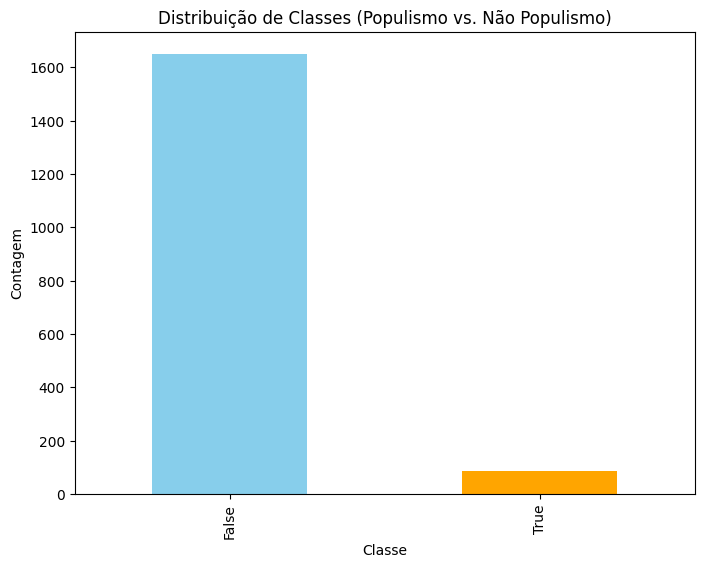

In [12]:
# Distribuição de classes
plt.figure(figsize=(8, 6))
populista['populismo'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribuição de Classes (Populismo vs. Não Populismo)')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

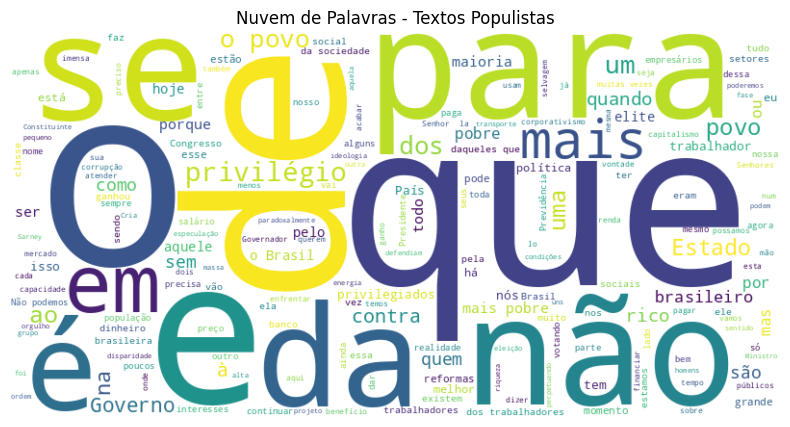

In [13]:
# Nuvem de palavras para textos populistas
populist_texts = ' '.join(populista[populista['populismo'] == True]['frases'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(populist_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Textos Populistas')
plt.show()

## Modelling

### Pré processamento

#### Padronziar formato das letras

In [14]:
populista['frases'] = populista['frases'].str.lower().tolist()
populista.head()

,pres_label,date,frases,populismo
2,Sarney-I,1985-04-21,"ninguém o excedeu no amor do povo, que acompan...",False
135,Sarney-I,1985-05-02,"aqui estão educadores, estudantes, cientistas,...",False
446,Sarney-I,1985-05-18,"na manhã de 15 de janeiro, há tão poucos e den...",False
469,Sarney-I,1985-05-18,"antes, estávamos juntos para, em nome do povo,...",False
513,Sarney-I,1985-05-24,"o nordeste é, sobretudo, um estado de espírito.",False


#### Lematização e Stematização

Definindo stop words, e caracteres especiais

In [15]:
nlp = spacy.load("pt_core_news_sm")

stop_words_ptbr = stopwords.words('portuguese')

def remove_accents(text):
    """
    Remove acentos, til e cedilha do texto.
    """
    text = unicodedata.normalize('NFD', text)
    text = re.sub(r'[\u0300-\u036f]', '', text)  # Remove diacríticos (acentos, til)
    text = text.replace('ç', 'c').replace('Ç', 'C')  # Substitui cedilha
    return text


Lematização e Stematização, remoção de stop words, de caracteres especiais, e vetorização-tokenização

In [16]:
# Stemming para português
stemmer = RSLPStemmer()

class StemTokenizer:
    def __init__(self, stop_words=None, use_stemming=False):
        self.stop = stop_words if stop_words else []
        self.use_stemming = use_stemming

    def __call__(self, doc):
        """
        Tokeniza e lematiza ou faz stemming de um documento de texto.
        """
        doc = remove_accents(doc.lower())  # Remove acentos e normaliza para minúsculas
        tokens = nlp(doc)  # Processa com Spacy
        if self.use_stemming:
            return [stemmer.stem(token.text) for token in tokens if token.is_alpha and token.text not in self.stop]
        else:
            return [token.lemma_ for token in tokens if token.is_alpha and token.text not in self.stop]


In [17]:
# Carregar embeddings pré-treinados (ex: Word2Vec em português)
word2vec_model = KeyedVectors.load_word2vec_format(file_path , binary=True)

def text_to_embedding(text, model=word2vec_model, max_len=100):
    """
    Converte texto em uma sequência de embeddings.
    """
    tokens = stem(text)  # Usa o tokenizador já definido
    embeddings = [model[token] if token in model else np.zeros(model.vector_size) for token in tokens]
    embeddings = pad_sequences([embeddings], maxlen=max_len, padding='post', dtype='float32')
    return embeddings[0]

Aplicação da tokenização e lematização

In [18]:
stem = StemTokenizer(stop_words=stop_words_ptbr)
vectorizer = CountVectorizer(tokenizer=stem)

In [19]:
# Mantendo a coluna original "frases" e criando uma nova coluna para a tokenização
populista['tokenized_frases'] = populista['frases'].apply(lambda x: stem(x))

# Visualizando para verificar
print(populista[['tokenized_frases']].head(20))

                                       tokenized_frases
2     [ninguar, exceder, amor, povo, acompanhar, lon...
135   [aqui, estao, educador, estudante, cientista, ...
446   [manha, janeiro, ha, tao, pouco, denso, mês, d...
469   [antes, estava, junto, nome, povo, conquistar,...
513             [nordeste, sobretudo, estado, espirito]
663   [grande, alegria, imenso, prazer, receber, tod...
712   [visao, espiritual, porque, verifiqueir, em aq...
742   [futuro, mundo, nao, sera, marcar, rico, pobre...
783   [achar, mundo, futuro, nao, sera, balizar, ric...
834   [poder, ter, correr, regiao, rico, todo, mundo...
838   [em este, instante, dever, seguir, exemplo, ag...
853   [ontem, reuniao, so, ouvia, falar, simon, nao,...
896   [dizer, tambem, ir, repetir, aqui, rio, sao, F...
952   [canal, complementar, privilegiar, porque, col...
1419  [nao, poder, homem, publico, ter, hoje, outro,...
1423  [ir, comecar, alia, ja, comecar, realidade, de...
1495  [lembrar, promessa, rejeitar, compromisso,

### Modelos

#### Preparação para os modelos de Machine Learning

Divisão de treino e teste

In [20]:
X = populista['tokenized_frases']
y = populista['populismo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Vetorização de dados

In [21]:
# Converter X_train e X_test para strings para o TF-IDF e RandomOverSampler
X_train_str = [' '.join(tokens) for tokens in X_train]
X_test_str = [' '.join(tokens) for tokens in X_test]

Vetorização estatística TF-IDF de dados

In [22]:
# Vetorização TF-IDF com dados balanceados para Machine Learning
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_str)
X_test_tfidf = vectorizer.transform(X_test_str)

Balanceamento de dados

In [23]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

In [24]:
X_resampled_str = vectorizer.inverse_transform(X_resampled)
X_resampled_str = [' '.join(tokens) for tokens in X_resampled_str]

#### Modelos de Machine Learning

Modelos Random Forest (Ensemble), Naive Bayes (Estatístico), e Suport Vector Machine (Natural Language Processing)

In [26]:
# Criação de objeto dos modelos
rf = RandomForestClassifier(random_state=42)  # Ensemble
svm = SVC(random_state=42) # NLP
nb = MultinomialNB() # Estatístico

# Treinar os modelos
rf.fit(X_resampled, y_resampled);
svm.fit(X_resampled, y_resampled);
nb.fit(X_resampled, y_resampled);

#### Preparação para os modelos de DeepLearning

Parâmetros

In [ ]:
# Parâmetros para Deep Learning
MAX_WORDS = 10000
MAX_LEN = 100
EMBEDDING_DIM = 100

Tokenizador

In [ ]:
# Tokenizador para Deep Learning (reutilizando X_resampled_str)
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_resampled_str)

X_train_seq = tokenizer.texts_to_sequences(X_resampled_str)
X_test_seq = tokenizer.texts_to_sequences(X_test_str)

Padding

In [ ]:
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

#### Modelos de Deep Learning

Modelos Convolutional Neural Networks (CNN), Bayesian Neural Networks (BNN), Long Short-Term Memory (RNN)

## Evalutation

In [ ]:
# Modelo Convolutional Neural Networks (CNN)
cnn_model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Modelo LSTM
lstm_model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Modelo Bayesian Neural Network (BNN) - usando Dropout como regularização bayesiana
bnn_model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(64, return_sequences=True, dropout=0.5),
    LSTM(64, dropout=0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Treinar modelos
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.F1Score(), tf.keras.metrics.Recall()])
cnn_model.fit(X_train_pad, y_resampled, epochs=50, batch_size=32, validation_data=(X_test_pad, y_test), callbacks=[EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True)])

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - f1_score: 0.6682 - loss: 0.5486 - recall_8: 0.6895 - val_f1_score: 0.0949 - val_loss: 0.1698 - val_recall_8: 0.3846
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - f1_score: 0.6618 - loss: 0.0105 - recall_8: 1.0000 - val_f1_score: 0.0949 - val_loss: 0.2120 - val_recall_8: 0.3846
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - f1_score: 0.6677 - loss: 0.0054 - recall_8: 0.9983 - val_f1_score: 0.0949 - val_loss: 0.2169 - val_recall_8: 0.3846
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - f1_score: 0.6690 - loss: 0.0026 - recall_8: 1.0000 - val_f1_score: 0.0949 - val_loss: 0.2176 - val_recall_8: 0.3846
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1_score: 0.6560 - loss: 0.0037 - recall_8: 0.9989 - val_f1_score: 0.0949 - val_loss: 0.2151 - val_recall_8: 0.4615
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - f1_score: 0.6656 - loss: 0.0040 - recall_8: 1.0000 - val_f1_score: 0.0949 - val_loss: 0.2242 - val_re

In [ ]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.F1Score(), tf.keras.metrics.Recall()])
lstm_model.fit(X_train_pad, y_resampled, epochs=50, batch_size=32, validation_data=(X_test_pad, y_test), callbacks=[EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True)])

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 311ms/step - f1_score: 0.6684 - loss: 0.4852 - recall_9: 0.7837 - val_f1_score: 0.0949 - val_loss: 0.2468 - val_recall_9: 0.3846
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - f1_score: 0.6718 - loss: 0.0896 - recall_9: 0.9706 - val_f1_score: 0.0949 - val_loss: 0.2374 - val_recall_9: 0.3846
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 273ms/step - f1_score: 0.6624 - loss: 0.0119 - recall_9: 1.0000 - val_f1_score: 0.0949 - val_loss: 0.2695 - val_recall_9: 0.3846
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - f1_score: 0.6651 - loss: 0.0148 - recall_9: 0.9982 - val_f1_score: 0.0949 - val_loss: 0.2802 - val_recall_9: 0.3846
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - f1_score: 0.6795 - loss: 0.0095 - recall_9: 1.0000 - val_f1_score: 0.0949 - val_loss: 0.2964 - val_recall_9: 0.3846
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 282ms/step - f1_score: 0.6728 - loss: 0.0045 - recall_9: 1.0000 - val_f1_score: 0.0949 - val_loss: 0.29

In [ ]:
bnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
bnn_model.fit(X_train_pad, y_resampled, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - auc_2: 0.4801 - loss: 0.6945 - val_auc_2: 0.4946 - val_loss: 0.7081
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - auc_2: 0.5052 - loss: 0.6947 - val_auc_2: 0.4980 - val_loss: 0.6959
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - auc_2: 0.4941 - loss: 0.6939 - val_auc_2: 0.5181 - val_loss: 0.7558
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - auc_2: 0.4840 - loss: 0.6942 - val_auc_2: 0.4758 - val_loss: 0.6360
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - auc_2: 0.4891 - loss: 0.6952 - val_auc_2: 0.5000 - val_loss: 0.6961


In [27]:
def evaluate_model(model, X_test, y_test):
    """
    Avalia o modelo e encontra o threshold ideal para maximizar o F1-score.

    Parâmetros:
    - model: modelo treinado com método predict
    - X_test: conjunto de teste
    - y_test: rótulos reais

    Retorna:
    - Métricas correspondentes: accuracy, precision, recall, f1
    """
    y_pred_prob = model.predict(X_test).flatten()  # Obtém probabilidades previstas

    thresholds = np.linspace(0.1, 0.9, 81)
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_pred_prob > threshold).astype("int32")
        f1 = f1_score(y_test, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Aplicar o melhor threshold encontrado
    y_pred = (y_pred_prob > best_threshold).astype("int32")

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(best_threshold)
    return accuracy, precision, recall, f1


In [28]:
rf_results = evaluate_model(rf, X_test_tfidf, y_test)
svm_results = evaluate_model(svm, X_test_tfidf, y_test)
nb_results = evaluate_model(nb, X_test_tfidf, y_test)


print(f"Random Forest: F1_Score={round(rf_results[3],4)}, Recall={round(rf_results[2],4)}, Precision={round(rf_results[1],4)}, Accuracy={round(rf_results[0],4)}")
print(f"Suport Vector Machine: F1_Score={round(svm_results[3],4)}, Recall={round(svm_results[2],4)}, Precision={round(svm_results[1],4)}, Accuracy={round(svm_results[0],4)}")
print(f"Naive Bayes: F1_Score={round(nb_results[3],4)}, Recall={round(nb_results[2],4)}, Precision={round(nb_results[1],4)}, Accuracy={round(nb_results[0],4)}")

0.1
0.1
0.1
Random Forest: F1_Score=0.1429, Recall=0.0769, Precision=1.0, Accuracy=0.954
Suport Vector Machine: F1_Score=0.375, Recall=0.2308, Precision=1.0, Accuracy=0.9617
Naive Bayes: F1_Score=0.2927, Recall=0.4615, Precision=0.2143, Accuracy=0.8889


In [ ]:
cnn_results = evaluate_model(cnn_model, X_test_pad, y_test)
lstm_results = evaluate_model(lstm_model, X_test_pad, y_test)
bnn_results = evaluate_model(bnn_model, X_test_pad, y_test)

print(f"Convolutional Neural Networks: F1_Score={round(cnn_results[3],4)}, Recall={round(cnn_results[2],4)}, Precision={round(cnn_results[1],4)}, Accuracy={round(cnn_results[0],4)}")
print(f"Long Short-Term Memory: F1_Score={round(lstm_results[3],4)}, Recall={round(lstm_results[2],4)}, Precision={round(lstm_results[1],4)}, Accuracy={round(lstm_results[0],4)}")
print(f"Bayesian Neural Networks: F1_Score={round(bnn_results[3],4)}, Recall={round(bnn_results[2],4)}, Precision={round(bnn_results[1],4)}, Accuracy={round(bnn_results[0],4)}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.43000000000000005
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
0.87
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
0.5
Convolutional Neural Networks: F1_Score=0.5455, Recall=0.4615, Precision=0.6667, Accuracy=0.9617
Long Short-Term Memory: F1_Score=0.3636, Recall=0.3077, Precision=0.4444, Accuracy=0.9464
Bayesian Neural Networks: F1_Score=0.0956, Recall=1.0, Precision=0.0502, Accuracy=0.0575


#### Classificações com Generative AI

Modelos Chat GPT